# Building New Data Driven PRF Models for `pandora-psf` Visible

`pandora-psf` uses grids of model PSFs to create estimates of the PRF of a given source. It is important to update these models using real data, for example from commissioning data. This notebook shows how to build a data driven PRF model to use in `pandora-psf`.

In [1]:
import lamatrix
import pandorapsf as pp
import pandorasat as ps
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

## Step 0: Gathering data

In this step we will gather the data we're going to use. Here, we're going to simulate data using the theoretical PSF for Pandora. In reality, you will build this dataset from observed data.

In [2]:
visda = ps.VisibleDetector()

# Load in PSF model
p = pp.PSF.from_name("VISDA")

# Uniformly sample across the detector
rcent, ccent = np.random.uniform(1024 - 600, 1024 + 600, size=(2, 2000))

# Simulate some reasonable magnitudes
mags = -np.abs(np.random.normal(0, 2, size=len(rcent))) + 14

# Flux in a 0.2s integration on visda
fluxes = (visda.mag_to_flux(mags) * visda.integration_time).value

In [3]:
R, C = p.prf(rcent[0], ccent[0])[:2]
R, C = np.meshgrid(R - np.floor(rcent[0]).astype(int), C - np.floor(ccent[0]).astype(int), indexing='ij')
prfs = np.asarray([p.prf(r - 1024, c - 1024)[2] for r, c in zip(rcent, ccent)])

dr3d = (R - (rcent[:, None, None] % 1))
dc3d = (C - (ccent[:, None, None] % 1))
# r3d = (R*0 + (rcent[:, None, None]))
# c3d = (C*0 + (ccent[:, None, None]))

In [4]:
data = np.random.poisson(prfs * fluxes[:, None, None])

# # Apply background to every read, units of electrons
data += np.random.poisson(
    (visda.background_rate * visda.integration_time.to(u.second)).value,
    size=data.shape,
).astype(int)

# # Add poisson noise for the dark current to every frame, units of electrons
data += np.random.poisson(
    lam=(visda.dark * visda.integration_time.to(u.second)).value,
    size=data.shape,
).astype(int)

Below are some examples of the synthetic data. We see various PSF shapes across the focal plane. 

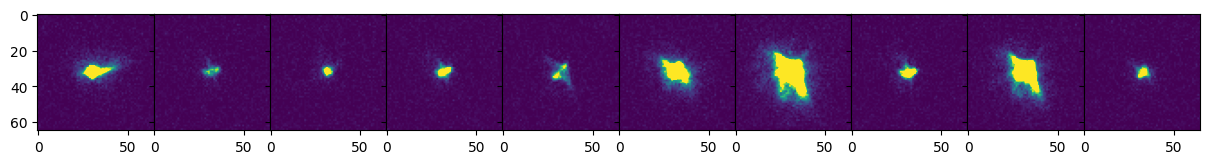

In [5]:
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(15, 3))
for idx in range(10):
    ax[idx].imshow(data[idx], vmin=0, vmax=50)
plt.subplots_adjust(wspace=0)

# Step 1: Fitting the data

We will require the following ingredients to make the PRF model

1. Data of sources, which has been background subtracted
2. A grid of the positions on the focal plane
3. A grid of positions from the source
4. An estimate of the flux

We will be building a grid of models. We will pick a resolution for that grid.

In [6]:
sources = np.asarray([rcent, ccent, fluxes]).T
row3d, col3d = R + np.floor(rcent).astype(int)[:, None, None], C + np.floor(ccent).astype(int)[:, None, None]

# Mask out any points that have multiple sources on them!
mask = data > 20
mask &= data/fluxes[:, None, None] > 1e-5

In [7]:
npoints = 5
grid_range = (1024 - 400, 1024 + 400)
grid_R, grid_C = np.meshgrid(np.linspace(*grid_range, npoints), np.linspace(*grid_range, npoints), indexing='ij')
dg = np.diff(grid_R, axis=0)[0][0]/2

We can plot the data in each segment of the focal plane

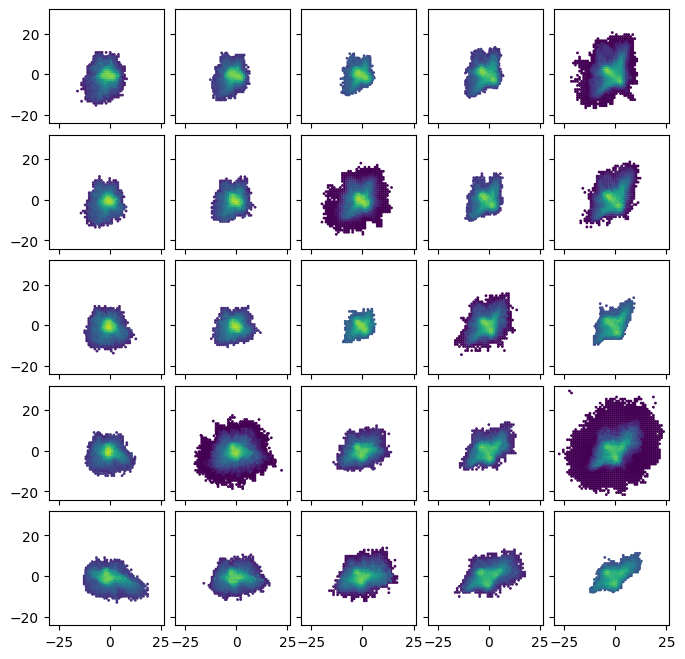

In [8]:
fig, ax = plt.subplots(npoints, npoints, sharex=True, sharey=True, figsize=(8, 8))
for idx in range(grid_R.shape[0]):
    for jdx in range(grid_R.shape[1]):
        gr, gc = grid_R[idx, jdx], grid_C[idx, jdx]
        k = (rcent > (gr - dg)) & (rcent < (gr + dg)) & (ccent > (gc - dg)) & (ccent < (gc + dg))
        ax[idx, jdx].scatter(dc3d[k[:, None, None] & mask], dr3d[k[:, None, None] & mask], c=np.log10((data/fluxes[:, None, None])[k[:, None, None] & mask]), s=1, vmin=-4, vmax=-1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

We now need to fit the data

In [9]:
from lamatrix import SparseSpline, Spline, DistributionsContainer

In [10]:
# Tune the spline parameters here for a different fit. Note the computational cost scales strongly with the number of knots!
model = SparseSpline('r', knots=np.arange(-20, 20, 1.5)) * SparseSpline('c', knots=np.arange(-20, 20, 1.5))
model.priors = DistributionsContainer([(-6, 10) for count in range(model.width)])

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_37187/1877068764.py:8: RuntimeWarning: invalid value encountered in divide
  model.fit(c=dc3d[k[:, None, None] & mask], r=dr3d[k[:, None, None] & mask], data=np.log10((data/fluxes[:, None, None])[k[:, None, None] & mask]), errors=(data**0.5/data)[k[:, None, None] & mask])
/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_37187/1877068764.py:19: RuntimeWarning: divide by zero encountered in log10
  ax[idx, jdx].pcolormesh(cm, rm, np.log10(bf), vmin=-4, vmax=-1)


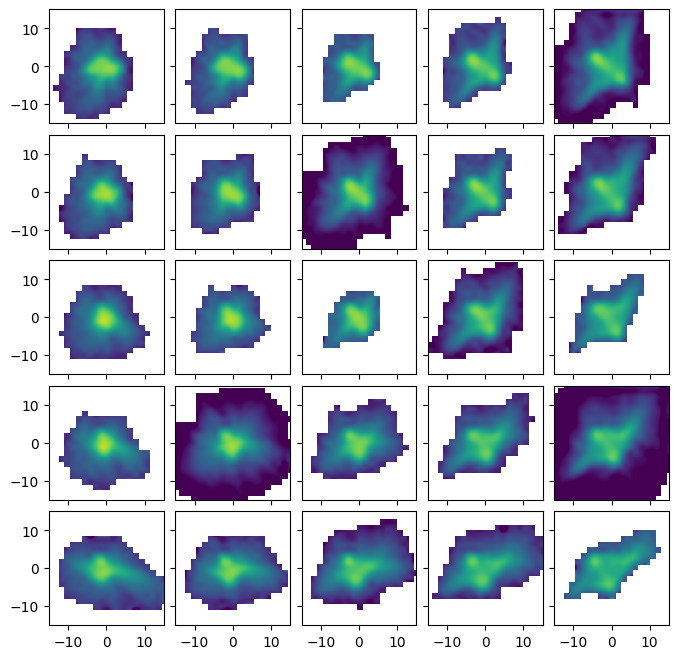

In [11]:
rm, cm = np.mgrid[-15:15:256j, -15:15:256j]
prf_model = np.zeros((*grid_R.shape, *rm.shape))
fig, ax = plt.subplots(npoints, npoints, sharex=True, sharey=True, figsize=(8, 8))
for idx in range(grid_R.shape[0]):
    for jdx in range(grid_R.shape[1]):
        gr, gc = grid_R[idx, jdx], grid_C[idx, jdx]
        k = (rcent > (gr - dg)) & (rcent < (gr + dg)) & (ccent > (gc - dg)) & (ccent < (gc + dg))
        model.fit(c=dc3d[k[:, None, None] & mask], r=dr3d[k[:, None, None] & mask], data=np.log10((data/fluxes[:, None, None])[k[:, None, None] & mask]), errors=(data**0.5/data)[k[:, None, None] & mask])
        X = model.design_matrix(c=dc3d[k[:, None, None] & mask], r=dr3d[k[:, None, None] & mask])

        # Only use splines where several points inform the fit
        j = np.asarray((X != 0).sum(axis=0))[0] > 5
        w = np.asarray([m if p else np.nan for m, p in zip(model.posteriors.mean, j)])

        X = model.design_matrix(c=cm.ravel(), r=rm.ravel())
        bf = X.dot(w).reshape(cm.shape)
        bf = 10**(bf)
        bf[~np.isfinite(bf)] = 0
        ax[idx, jdx].pcolormesh(cm, rm, np.log10(bf), vmin=-4, vmax=-1)
        prf_model[idx, jdx] = bf/np.trapz(np.trapz(bf, rm, axis=0), cm[0])
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Step 2: Packaging

Now we have our model we need to package it as a fits file so that `pandora-psf` can load it

In [23]:
from astropy.io import fits
from astropy.time import Time

In [24]:
pp.config['SETTINGS']['data_dir']

'/Users/chedges/Library/Application Support/pandorapsf'

In [25]:
fits.open("/Users/chedges/Library/Application Support/pandorapsf/pandora_vis_psf.fits")[2].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   11                                                  
NAXIS2  =                    9                                                  
NAXIS3  =                    9                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'ROW     '           / extension name                                 
UNIT    = 'pix     '                                                            

In [36]:
hdu0 = fits.PrimaryHDU()
hdu0.header['CREATOR'] = ("Pandora DPC Software", "Software that created this file")
hdu0.header['AUTHOR'] = ("Christina Hedges", "Person or group that created this file")
hdu0.header['VERSION'] = ("Synthetic_V1", "")
hdu0.header['DATASRC'] = ("SIMULATION", "")
hdu0.header['DATE'] = Time.now().isot
hdu0.header["TELESCOP"] = ("NASA Pandora", "telescope")
hdu0.header["CAMERAID"] = ("PcoCam", "ID of camera used in acquisition")
hdu0.header["INSTRMNT"] = ("VISDA", "instrument")
hdu0.header['IMSIZE0'] = (2048, "Size of the full detector image in ROW")
hdu0.header['IMCRNR0'] = (0, "Center of the image in ROW.")
hdu0.header['IMSIZE1'] = (2048, "Size of the full detector image in COLUMN")
hdu0.header['IMCRNR1'] = (0, "Center of the image in COLUMN.")
hdu0.header['PIXSIZE'] = (visda.pixel_size.value, 'PSF pixel size in micron / pix')
hdu0.header['SUBPIXSZ'] = (np.diff(rm, axis=0).mean() * visda.pixel_size.value, 'PSF sub pixel size in micron / pix')

hdu1 = fits.CompImageHDU(prf_model, name='PSF')
hdu2 = fits.ImageHDU(grid_R, name='ROW')
hdu2.header['UNIT'] = 'pix'
hdu2.header['CENTER'] = (1024, "Offset to apply to grid points so they are centered in image.")
hdu3 = fits.ImageHDU(grid_C, name='COLUMN')
hdu3.header['UNIT'] = 'pix'
hdu2.header['CENTER'] = (1024, "Offset to apply to grid points so they are centered in image.")
hdulist = fits.HDUList([hdu0, hdu1, hdu2, hdu3])
hdulist.writeto("pandora_vis_prf.fits", overwrite=True)

In [37]:
!du -sh pandora_vis_prf.fits

1.7M	pandora_vis_prf.fits


# Step 3: Using

Now we have created our file we can use it in `pandora-psf`

In [16]:
from pandorapsf import PRF

In [17]:
prf = PRF.from_file("visda", "pandora_vis_prf.fits", extrapolate=True)

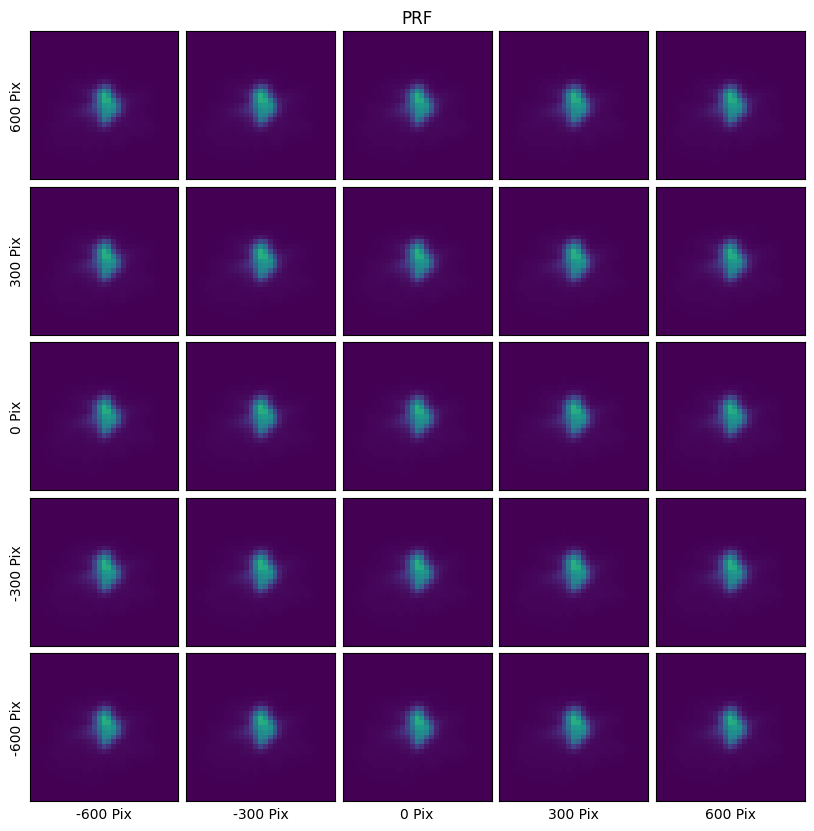

In [18]:
prf.plot_spatial(n=5)#, image_type='prf')

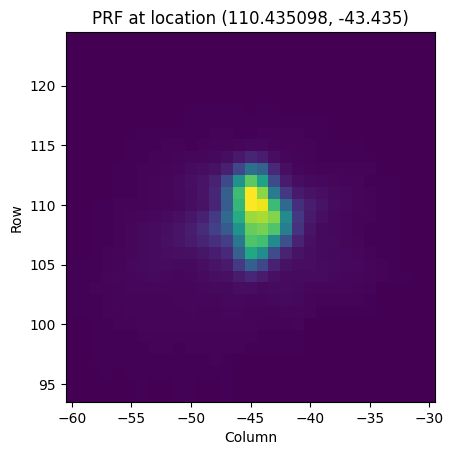

In [19]:
location = (110.435098, -43.4350)
r, c, im = prf.prf(*location)
fig, ax = plt.subplots()
plt.pcolormesh(c, r, im)
ax.set(xlabel='Column', ylabel='Row', aspect='equal', title=f"PRF at location {location}");

# Step 4: Updating the best fit model

Now that we have a model we have to update the package. 

You should be familiar with the steps to update the PSF models from the documenation:
- https://pandoramission.github.io/pandora-psf/uploading-new-files/

To update PRF files you should 
1. Update the configuration file set up in the `__init__.py` file to reflect your creation date
2. Upload the files to zenodo
3. Update the configuration file set up in the `__init__.py` file to reflect your zenodo URL
4. Check the `from_name` method looks correct given your updates.

In [66]:
ps.VisibleDetector().zeropoint/(2.49769e-9 * u.Unit('erg / (Angstrom s cm2)'))

<Quantity 1.50695753>

<Axes: title={'center': 'VISDA'}, xlabel='Wavelength [$\\mathrm{\\mu m}$]', ylabel='Sensitivity [$\\mathrm{\\frac{cm^{2}\\,e^{-}}{erg}}$]'>

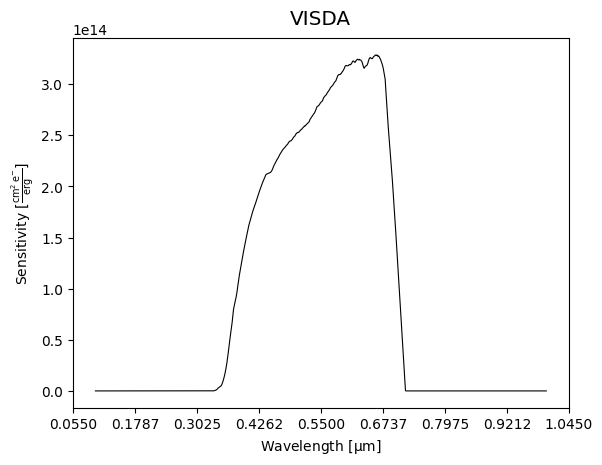

In [110]:
visda = ps.VisibleDetector()

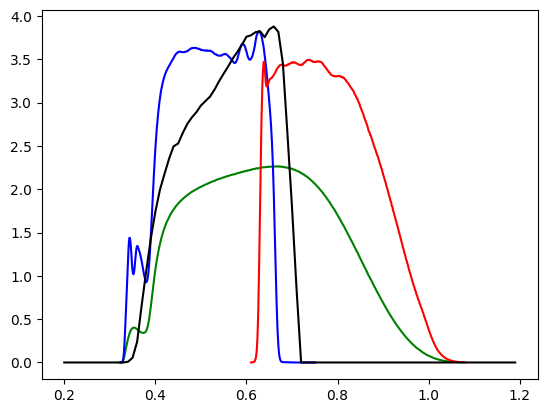

In [117]:
# ax = ps.VisibleDetector().plot_sensitivity()

for band, color in zip(["G", "Gbp", "Grp"], ["g", "b", "r"]):
    df = pd.read_csv(f"https://svo2.cab.inta-csic.es/svo/theory/fps3/getdata.php?format=ascii&id=GAIA/GAIA3.{band}", header=None, sep=' ')
    w, s = np.asarray(df[0].values, dtype=float)/1e4, np.asarray(df[1].values, dtype=float)
    s /= np.trapz(s, w)
    plt.plot(w, s, label=band, color=color)

w = np.arange(0.2, 1.2, 0.01) * u.micron
s = visda.sensitivity(w)
s /= np.trapz(s, w)
plt.plot(w.value, s.value, c='k')

In [118]:
4.16921e-9

4.16921e-09

In [122]:
visda.estimate_zeropoint().value/4.16921e-9

/var/folders/bv/0t7fjlgx0mx3_3bdhxqzd7bmh_67k0/T/ipykernel_4152/1040079896.py:1: DeprecationWarning: 'esimate_zeropoint' is deprecated and will be removed in a future version. Use 'zeropoint' instead.
  visda.estimate_zeropoint().value/4.16921e-9


0.9027880008070859

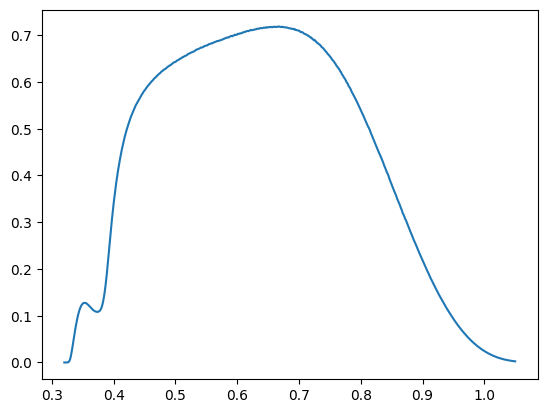

In [99]:
plt.plot(w, s)